# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl




In [4]:
%%bash
nrnivmodl

Creating x86_64 directory for .o files.

/root/Documents/tutorial_4
MorrisLecar.mod netstim2.mod
MorrisLecar.mod netstim2.mod
"/usr/local/nrn/x86_64/bin/nocmodl" MorrisLecar
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o MorrisLecar.lo MorrisLecar.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c MorrisLecar.c  -fPIC -DPIC -o .libs/MorrisLecar.o
"/usr/local/nrn/x86_64/bin/nocmodl" netstim2
Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not
located in a section and is not associated with an integrator
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/li

Translating MorrisLecar.mod into MorrisLecar.c
Thread Safe
Translating netstim2.mod into netstim2.c
Thread Safe


# 1. Cell objects

In Python, you can define custom data types that you can use to organize data and related operations. For example, so far we have worked with cell models in NEURON, which have common attributes and operations as:

1. Sections and segments,
2. Combining sections to define the morphology of a cell,
3. Active mechanisms and inserting them,
4. Synapses and connecting them to other cells, etc.

We can collect these into a cell object as follows:

In [1]:
from neuron import h, gui

class Cell:
    """ Cell class"""
    
    # When a cell object is created this function is called first.
    # Note "self" in definition
    def __init__(self):
        
        self.synlist = []      # list of synapses in this cell

        # here are some operations to create a cell
        self.create_sections()
        self.build_topology()
        self.build_subsets()
        self.define_geometry()
        self.define_biophysics()
        self.create_synapses()

    # At this stage, we leave most of them unimplemented
    # This technique is called "the Template pattern"
    def create_sections(self):
        raise NotImplementedError("create_section() is not implemented.")

    def build_topology(self):
        raise NotImplementedError("build_topology() is not implemented.")
    
    def build_subsets(self):
        raise NotImplementedError("build_subsets() is not implemented.")

    def define_geometry(self):
        raise NotImplementedError("define_geometry() is not implemented.")

    def define_biophysics(self):
        raise NotImplementedError("define_biophysics() is not implemented.")

    def create_synapses(self):
        raise NotImplementedError("create_synapses() is not implemented.")
    
    # Here are something that will be commonly used by every cell
    # built based on this template
    
    def connect2target(self, target, thresh=0):
        """Make a new NetCon with this cell's membrane
        potential at the soma as the source (i.e. the spike detector)
        onto the target passed in (i.e. a synapse on a cell).
        Subclasses may override with other spike detectors."""
        nc = h.NetCon(self.soma(1)._ref_v, target, sec = self.soma)
        nc.threshold = thresh
        return nc


Now let's try to create a cell object!

In [2]:
cell1 = Cell()

NotImplementedError: create_section() is not implemented.

It will generate an error whenever you fail to provide any necessary step to define a proper cell. To implement those steps, we _subclass_ `Cell` as:

In [3]:
class PassiveNeuron(Cell):
    """Single compartment Morris-Lecar neuron"""
    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment
    
    def build_subsets(self):
        pass # single compartment
    
    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        self.soma.insert('pas')
        self.soma.g_pas = 5e-5
        
    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].tau2 = 3.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        self.synlist[-1].tau1 = 1.0
        self.synlist[-1].tau2 = 7.0
        
cell1 = PassiveNeuron()

In [4]:
# Inspect the last created cell
h.psection()

<__main__.PassiveNeuron object at 0x7fb5e008c518>.soma { nseg=1  L=15  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=15}
	insert capacitance { cm=1}
	insert pas { g_pas=5e-05 e_pas=-70}
	insert Exp2Syn { tau1=0.1 tau2=3 e=0}
	insert Exp2Syn { tau1=1 tau2=7 e=-75}
}


1.0

Now let's add some inputs to the cells. We will consider excitatory inputs first.

In [5]:
cell1.ext_inputs = {'exc': [], 'inh': []}
cell1.ext_ncs = {'exc': [], 'inh': []}

tstop = 500

Nexc = 400
fexc = 5.0 # 5 Hz
for i in range(Nexc):
    stim = h.NetStimFD(cell1.soma(0.5))
    stim.noise = 1 # maximally noisy stimulus
    stim.start = 0 # start from 0
    stim.duration = tstop
    stim.interval = 1000./fexc
    cell1.ext_inputs['exc'].append(stim)
    
    nc = h.NetCon(cell1.ext_inputs['exc'][-1], cell1.synlist[0])
    nc.weight[0] = 0.1e-3 # 0.1 pS
    cell1.ext_ncs['exc'].append(nc)


Then, we add a voltage recording to see the effect of the inputs,

In [46]:
tstop = 500
dt = 0.1
def run_recordV():
    dt = 0.1 # 10 kHz recording
    vrec = h.Vector()
    vrec.record(cell1.soma(0.5)._ref_v, dt)

    h.tstop = tstop
    h.v_init = -70
    h.init()
    h.run()

    return vrec.c()

vrec = run_recordV()


<IPython.core.display.Javascript object>


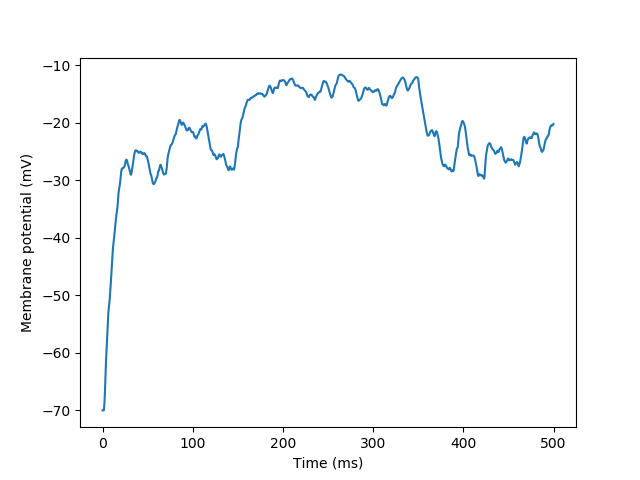

[Text(0,0.5,'Membrane potential (mV)'), Text(0.5,0,'Time (ms)')]

In [47]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
t = np.arange(vrec.size())*dt
ax.plot(t, vrec)
ax.set(xlabel='Time (ms)', ylabel='Membrane potential (mV)')

# 2. Current clamp

Here we add a current clamp to probe the membrane property:

In [25]:
ic = h.IClamp(cell1.soma(0.5))
ic.delay = 150
ic.dur = 200
ic.amp = 0.01

In [48]:
tstop = 500
dt = 0.1
def run_recordV():
    dt = 0.1 # 10 kHz recording
    vrec = h.Vector()
    vrec.record(cell1.soma(0.5)._ref_v, dt)

    h.tstop = tstop
    h.v_init = -70
    h.init()
    h.run()

    return vrec.c()

# Now we run 200 repeated simulations
vrecs = []
for i1 in range(10):
    for i2 in range(20):
        vrec = run_recordV()
        vrecs.append(vrec)
    print('Nrepeat =', (i1+1)*20)


Nrepeat = 20
Nrepeat = 40
Nrepeat = 60
Nrepeat = 80
Nrepeat = 100
Nrepeat = 120
Nrepeat = 140
Nrepeat = 160
Nrepeat = 180
Nrepeat = 200


Here we plot an average membrane potential:

<IPython.core.display.Javascript object>


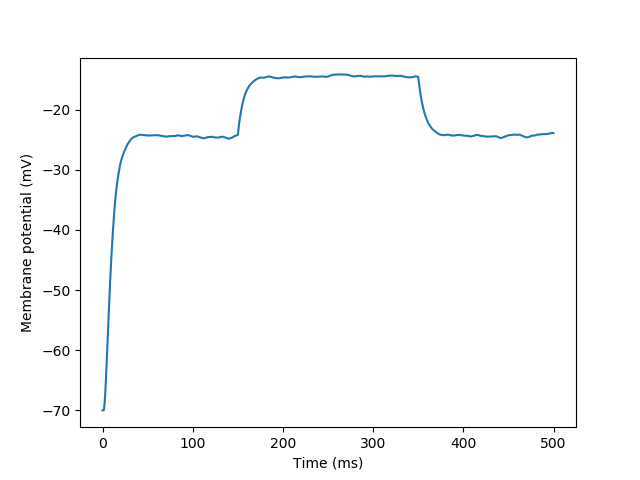

[Text(0,0.5,'Membrane potential (mV)'), Text(0.5,0,'Time (ms)')]

In [50]:
import CNSutil
vrec = CNSutil.convert_to_array(vrecs)
vrec = vrec.mean(axis=1)

fig, ax = plt.subplots()
t = np.arange(vrec.size)*dt
ax.plot(t, vrec)
ax.set(xlabel='Time (ms)', ylabel='Membrane potential (mV)')

How does this compare with no stimulus case? We "turn off" the inputs by setting the duation to zero:

<IPython.core.display.Javascript object>


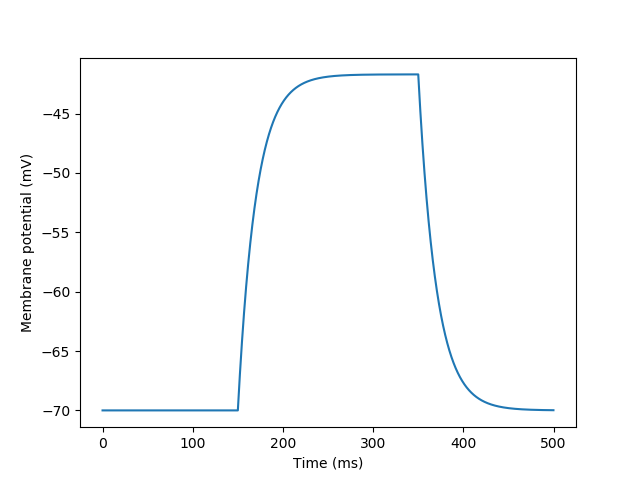

[Text(0,0.5,'Membrane potential (mV)'), Text(0.5,0,'Time (ms)')]

In [51]:
for stim in cell1.ext_inputs['exc']:
    stim.duration = 0

vrec = run_recordV()
fig, ax = plt.subplots()
t = np.arange(vrec.size())*dt
ax.plot(t, vrec)
ax.set(xlabel='Time (ms)', ylabel='Membrane potential (mV)')

# 3. AdEx Model

**Be sure to restart the kernel at this point**

Here we try a simple neuron with nonlinear spike generation mechanism, called the adaptive exponential intergrate-and-fire model (AdExpIF).

In [2]:
from neuron import h, gui
from cell_template import Cell

class AdExpIF(Cell):    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment
    
    def build_subsets(self):
        pass # single compartment
    
    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        self.soma.insert('pas')
        self.soma.g_pas = 5e-5
        self.adexp = h.AdExpIF(self.soma(0.5))
        self.adexp.tauw = 20
        self.adexp.EL = self.soma.e_pas
        self.adexp.GL = self.soma.g_pas*self.soma.L*self.soma.diam*h.PI
        self.adexp.vreset = -70

    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].tau2 = 3.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        self.synlist[-1].tau1 = 1.0
        self.synlist[-1].tau2 = 7.0

cell1 = AdExpIF()

# AdExpIF model requires better accuracy
cvode = h.CVode()
cvode.active(1)

1.0

<IPython.core.display.Javascript object>


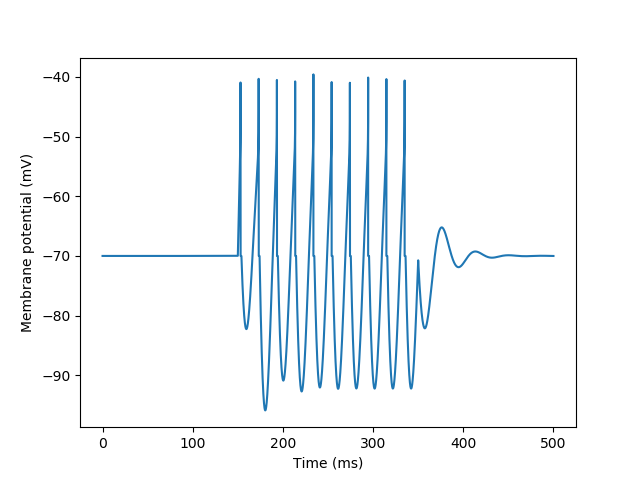

[Text(0,0.5,'Membrane potential (mV)'), Text(0.5,0,'Time (ms)')]

In [3]:
ic = h.IClamp(cell1.soma(0.5))
ic.delay = 150
ic.dur = 200
ic.amp = 0.05



tstop = 500
dt = 0.001 # 10 kHz recording
def run_recordV():
    vrec = h.Vector()
    vrec.record(cell1.soma(0.5)._ref_v, dt)

    h.tstop = tstop
    h.v_init = -70
    h.init()
    h.run()

    return vrec.c()

vrec = run_recordV()

%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
t = np.arange(vrec.size())*dt
ax.plot(t, vrec)
ax.set(xlabel='Time (ms)', ylabel='Membrane potential (mV)')

Now we add inputs,

In [5]:
cell1.ext_inputs = {'exc': [], 'inh': []}
cell1.ext_ncs = {'exc': [], 'inh': []}

tstop = 500

Nexc = 400
fexc = 5.0 # 5 Hz
for i in range(Nexc):
    stim = h.NetStimFD(cell1.soma(0.5))
    stim.noise = 1 # maximally noisy stimulus
    stim.start = 0 # start from 0
    stim.duration = tstop
    stim.interval = 1000./fexc
    cell1.ext_inputs['exc'].append(stim)
    
    nc = h.NetCon(cell1.ext_inputs['exc'][-1], cell1.synlist[0])
    nc.weight[0] = 0.1e-3 # 0.1 pS
    cell1.ext_ncs['exc'].append(nc)


In [ ]:
vrec = run_recordV()

%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
t = np.arange(vrec.size())*dt
ax.plot(t, vrec)
ax.set(xlabel='Time (ms)', ylabel='Membrane potential (mV)')

Let's add a spike counter in the cell and run the simulation multiple times:

In [8]:
apc = h.APCount(cell1.soma(0.5))
apc.thresh = cell1.adexp.vspike

def run_record_spikes():
    spikes = h.Vector()
    apc.record(spikes)

    h.tstop = tstop
    h.v_init = -70
    h.init()
    h.run()

    return spikes.c()

spikes_all = []
for i in range(50):
    spikes = run_record_spikes()
    spikes_all.append(spikes.to_python())


Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt
Changed dt


We convert the output in the following format:

```
spiketime, trial
0.1        1
0.2        1
0.15       2
0.2        2
.....
```

In [13]:
spiketimes = []
for i, sts in enumerate(spikes_all):
    for st in sts:
        spiketimes.append([st, i+1])
spiketimes = np.array(spiketimes)

In [14]:
spiketimes

array([[  6.90024031,   1.        ],
       [ 25.3643969 ,   1.        ],
       [ 45.52106243,   1.        ],
       ...,
       [438.92757706,  50.        ],
       [463.08690153,  50.        ],
       [484.95397797,  50.        ]])

<IPython.core.display.Javascript object>


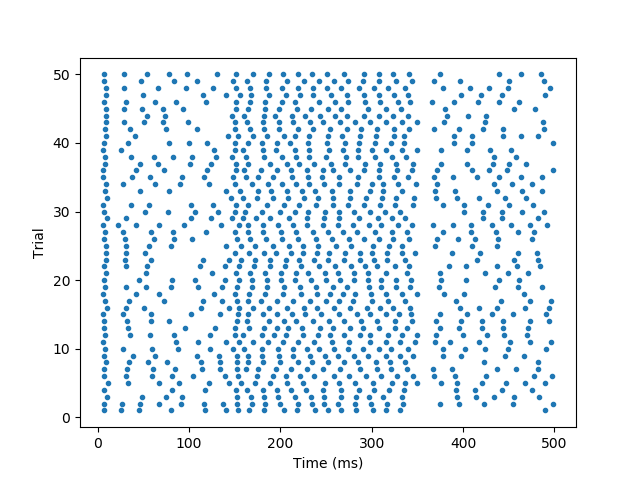

[Text(0,0.5,'Trial'), Text(0.5,0,'Time (ms)')]

In [18]:
%matplotlib nbagg
fig, ax = plt.subplots()

ax.plot(spiketimes[:,0], spiketimes[:,1], '.')
ax.set(xlabel="Time (ms)", ylabel = "Trial")

From this we can compute, the peristimulus histogram (PSTH) as well:

<IPython.core.display.Javascript object>


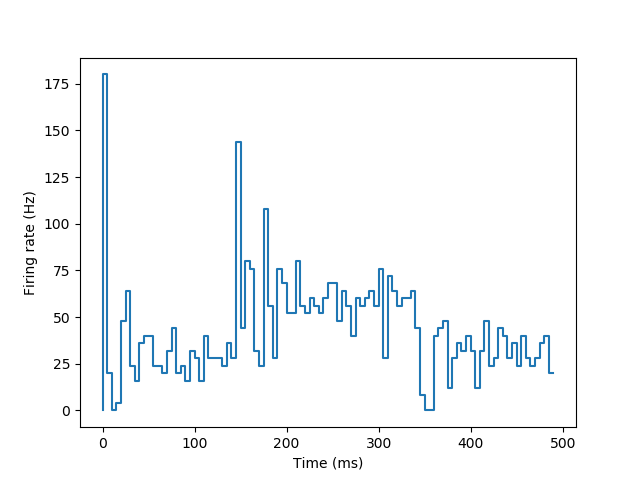

[Text(0,0.5,'Firing rate (Hz)'), Text(0.5,0,'Time (ms)')]

In [32]:
psth, t = np.histogram(spiketimes[:,0], np.arange(0, 500, 5))
psth = psth/50/5*1e3 # per trial and per ms and convert to Hz.
fig, ax = plt.subplots()
ax.step(t[:-1], psth)
ax.set(xlabel='Time (ms)', ylabel='Firing rate (Hz)')